# HW1 Report 

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import logging
import heapq
import time
import math
import os

## Part A: Data Download and Preprocessing
1. Download the POI Dataset:

    I downloaded the data from [Overpass Turbo] using the below query mentioned in the assignment. I exported the result of this query in ```data/interpreter.csv```

    ```python
    [out:csv(::id,::lat,::lon,'name'; true; ',')][timeout:3000];
    (
    node['amenity'](40.4774, -79.7624, 45.0159, -71.8562);
    node['shop'](40.4774, -79.7624, 45.0159, -71.8562);
    node['leisure'](40.4774, -79.7624, 45.0159, -71.8562);
    node['tourism'](40.4774, -79.7624, 45.0159, -71.8562);
    node['craft'](40.4774, -79.7624, 45.0159, -71.8562);
    node['office'](40.4774, -79.7624, 45.0159, -71.8562);
    node['healthcare'](40.4774, -79.7624, 45.0159, -71.8562);
    node['natural'](40.4774, -79.7624, 45.0159, -71.8562);
    node['man_made'](40.4774, -79.7624, 45.0159, -71.8562);
    node['historic'](40.4774, -79.7624, 45.0159, -71.8562);
    node['sport'](40.4774, -79.7624, 45.0159, -71.8562);
    node['place'](40.4774, -79.7624, 45.0159, -71.8562);
    node['railway'](40.4774, -79.7624, 45.0159, -71.8562);
    node['public_transport'](40.4774, -79.7624, 45.0159, -71.8562);
    node['highway'](40.4774, -79.7624, 45.0159, -71.8562);
    );
    out meta;/*fixed by auto repair*/
    ```

2. Identify and Remove Invalid Entries:
    - Removing rows with duplicate @id.
    - Ensuring @id is numeric for all the records.
    - Removing rows with missing @id, @lat, @lon.


In [2]:
osm_data = pd.read_csv('data/interpreter.csv')
osm_data.shape

(1552826, 4)

In [3]:
osm_data.columns

Index(['@id', '@lat', '@lon', 'name'], dtype='object')

In [4]:
# Removing rows with duplicate @id
osm_data.drop_duplicates(subset=['@id'], inplace=True)

# Ensuring @id is numeric, invalid values are converted to NaN
osm_data['@id'] = pd.to_numeric(osm_data['@id'], errors='coerce')
# Ensuring @lat is numeric, invalid values are converted to NaN
osm_data['@lat'] = pd.to_numeric(osm_data['@lat'], errors='coerce').astype(float)
# Ensuring @lon is numeric, invalid values are converted to NaN
osm_data['@lon'] = pd.to_numeric(osm_data['@lon'], errors='coerce').astype(float)

# Removing records with missing @id, @lat, @lon
osm_data.dropna(subset=['@id', '@lat', '@lon'], inplace=True)


In [5]:
if not os.path.exists('result'):
    os.makedirs('result')
    
# Create and configure logger
logging.basicConfig(filename="result/logging.log",
                    format='%(asctime)s %(message)s',
                    filemode='w', level=logging.INFO)
logger = logging.getLogger()

## Part B: Query Implementation: Brute Force Approach

### 1. K-Nearest Neighbors (KNN) Query Using Linear Search

In this section, I implement finding K-nearest neighbors using linear search. First, we randomly choose a target_id from the set of sampled dataset (or whole dataset), then we calculate euclidean distance of target_id to all other PoIs, and then sort the array based on the calculated distanced from target_id and retrieve the first K elements as Our K-nearest neighbors. The complexity is O(n) for finding distances to all other PoIs, O(nlogn) for sorting and O(K) for retrieving KNNs. 


**Note:** For a set of latitudes and longitudes, Euclidian distance is not an accurate measure since it does not take into account curvature of the earth's surface. Haversine distance is the conventional approach for finding distance between two geographical coordinates. Here, we calculated Euclidian distance on latitudes and longitudes because 1. PoIs are close to each other and earth's curvature is not that much. 2. The assignment explicitly asked us to calculate Euclidian distance between PoIs.


In [6]:
def euclidean_distance(point_x, point_y): 
    x0, y0 = point_x
    x1, y1 = point_y
    return ((x0 - x1)**2 + (y0 - y1)**2)**0.5

def knn_linear_search(dataset, target_id, k):
    # Find the target sample using linear search
    target_sample = dataset[dataset['@id'] == target_id]
    if target_sample.empty:
        raise ValueError('Target sample not found in dataset.')
    
    # Calculate the distance of the target sample from all other samples
    dataset['target_distance'] = dataset.apply(lambda row: euclidean_distance((row['@lat'], row['@lon']), (target_sample['@lat'].values[0], target_sample['@lon'].values[0])), axis=1)
    
    # Sort the dataset by distance
    dataset.sort_values(by='target_distance', inplace=True)
    
    # Return the k nearest neighbors
    neighbors = dataset.iloc[1:k+1].reset_index(drop=True) # Exclude the target sample
    
    return neighbors
    

#### Sanity Check: Test 5-NN on a sampled dataset and whole dataset

Here, we test KNN on a sampled dataset, assuming target_id is in dataset when using a fixed random_seed.
Hopefully, target_id falls in sampled_dataset when the examiner runs the cells. If not, test on the next cell using whole dataset.

In [ ]:
k = 5
N = 1000

# Sampling dataset of size N
dataset = osm_data.sample(n=N, random_state=42)

# Selecting a random target_id
target_id = 10286555485

# Finding the k nearest neighbors
test_knn_result = knn_linear_search(dataset, target_id, k)
test_knn_result

,@id,@lat,@lon,name,target_distance
0,8927594345,40.966847,-74.072517,NaN,0.013614
1,10303099289,40.974111,-74.038944,NaN,0.036443
2,2830434613,40.916461,-74.071348,DSW,0.037271
3,9795781803,40.908961,-74.035068,NaN,0.056191
4,7270863932,40.979878,-74.119536,Bibillia,0.056830


The below code took about 50s to run on the whole dataset!

In [8]:
k = 5
target_id = 10286555485
knn_linear_search_result = knn_linear_search(osm_data.copy(), target_id, k)
knn_linear_search_result

,@id,@lat,@lon,name,target_distance
0,10286555484,40.953624,-74.068873,NaN,0.000242
1,10286555481,40.953588,-74.068656,NaN,0.000463
2,10286555483,40.954115,-74.068730,NaN,0.000590
3,10286555503,40.953990,-74.069609,NaN,0.000594
4,10286555486,40.954327,-74.068970,NaN,0.000676


#### Evaluating KNN Performance (Varying N and K)

**Procedure to measure execution time:**

As requested in the assignment, for KNN using linear search, execution times was calculated for all $k \in \{1, 5, 10, 50, 100, 500\}$ and $N \in \{1000, 10000, 100000, 825171\}$. For each possible N and K, KNN was run 10 times on different target_ids and average execution time of the 10 runs were recorded. Therefor, the below code took overall time of 9m 37s to run.

Note that all plots are in **logarithmic scale** in y-axis. I did it on purpose to emphasize on scaling in execution times as we increase N. 

In [9]:
def measure_execution_time(dataset, k, N, func):
    # Sampling dataset of size N
    dataset = dataset.sample(n=N, random_state=42)

    # Selecting a random target_id
    target_id = np.random.choice(dataset['@id'])

    # Finding the k nearest neighbors and measuring execution time
    start_time = time.time()
    func(dataset, target_id, k)
    # knn_linear_search(dataset, target_id, k)
    end_time = time.time()
    
    return end_time - start_time

In [10]:
k_possible_values = [1, 5, 10, 50, 100, 500]
N_possible_values = [1000, 10000, 100000, 825171]

logger.info('KNN Linear Search Execution Time Measurement')
knn_linear_search_execution_times_list = [] # holds the execution times for different values of k and N
for N in N_possible_values:
    execution_times = []
    for k in k_possible_values:
        k_specific_execution_times = []
        for _ in range(10):
            k_specific_execution_times.append(measure_execution_time(osm_data, k, N, knn_linear_search))   
        logger.info(f'N={N}, k={k}, Average Execution Time={np.mean(k_specific_execution_times)} seconds.')
        print(f'N={N}, k={k}, Average Execution Time={np.mean(k_specific_execution_times)} seconds.')
        execution_times.append(np.mean(k_specific_execution_times))
    knn_linear_search_execution_times_list.append(execution_times)


N=1000, k=1, Average Execution Time=0.019655179977416993 seconds.
N=1000, k=5, Average Execution Time=0.01957271099090576 seconds.
N=1000, k=10, Average Execution Time=0.019449138641357423 seconds.
N=1000, k=50, Average Execution Time=0.01957089900970459 seconds.
N=1000, k=100, Average Execution Time=0.01948370933532715 seconds.
N=1000, k=500, Average Execution Time=0.019490146636962892 seconds.
N=10000, k=1, Average Execution Time=0.17524991035461426 seconds.
N=10000, k=5, Average Execution Time=0.17524416446685792 seconds.
N=10000, k=10, Average Execution Time=0.17546629905700684 seconds.
N=10000, k=50, Average Execution Time=0.17591469287872313 seconds.
N=10000, k=100, Average Execution Time=0.17535030841827393 seconds.
N=10000, k=500, Average Execution Time=0.176188063621521 seconds.
N=100000, k=1, Average Execution Time=1.753203773498535 seconds.
N=100000, k=5, Average Execution Time=1.7301602363586426 seconds.
N=100000, k=10, Average Execution Time=1.5975834131240845 seconds.
N=1

In [11]:
def plot_query_execution_times(execution_times_list, target_possible_values, N_possible_values, x_label, y_label, title, save_path, log_scale=True):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xticks(target_possible_values)
    # ax.set_yticks() 
    
    for i, N in enumerate(N_possible_values):
        ax.plot(target_possible_values, execution_times_list[i], label=f'N={N}', marker='o')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
    
    # Customize y-axis with uneven spacing
    if log_scale:
        ax.set_yscale('log')
    # ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1.0, 2.0, 5.0], numticks=10))
    
    plt.savefig(save_path)
    plt.show()

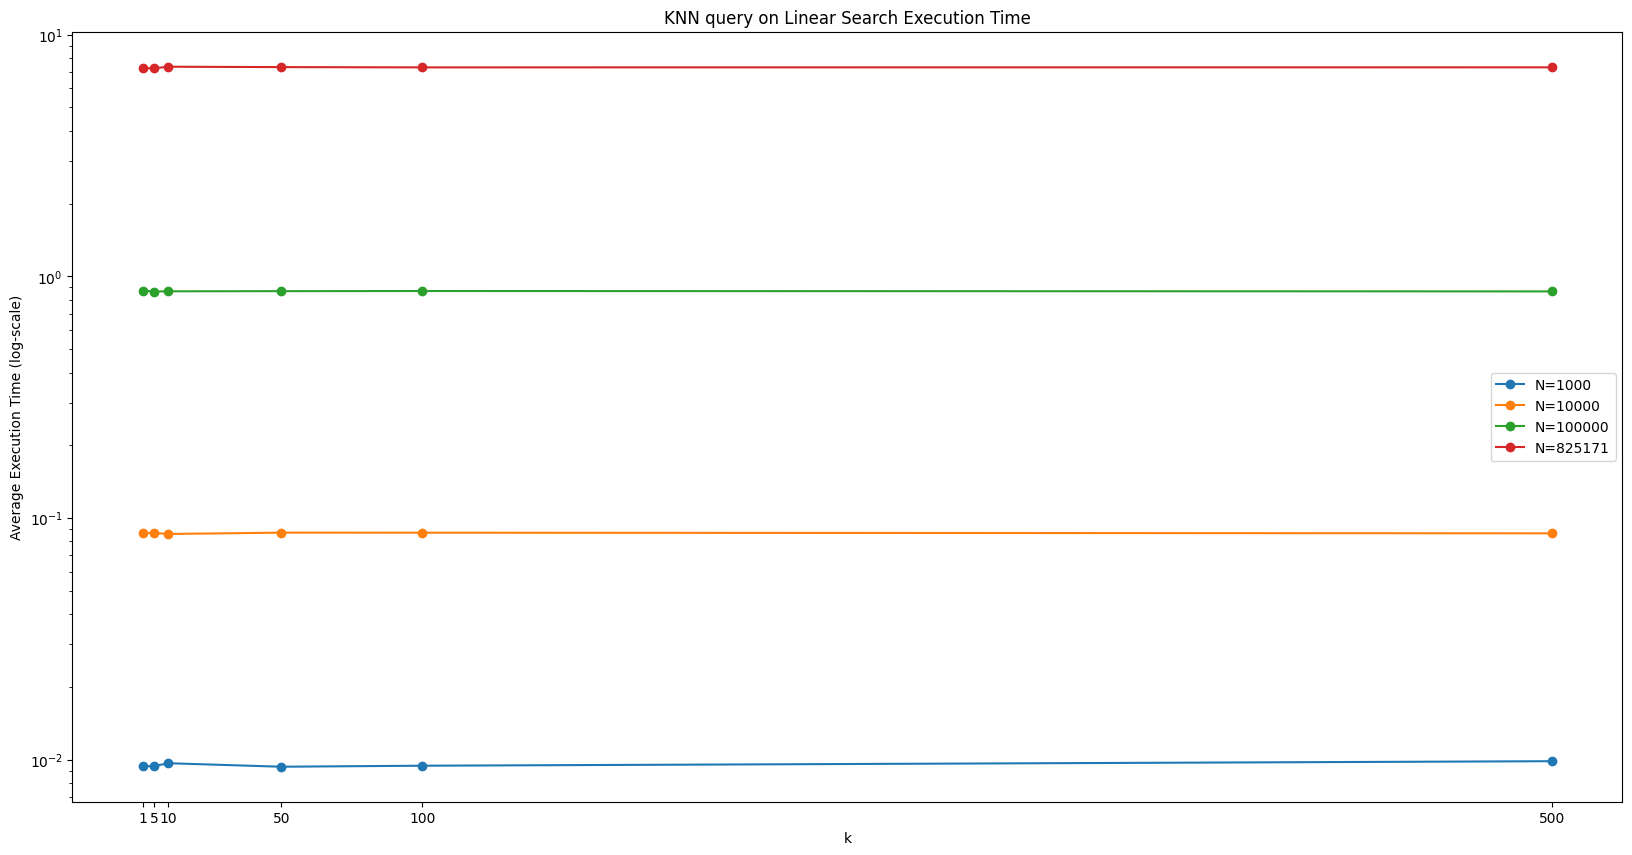

In [252]:
plot_query_execution_times(knn_linear_search_execution_times_list, k_possible_values, N_possible_values, 'k', 'Average Execution Time (log-scale)', 'KNN query on Linear Search Execution Time', 'result/knn_linear_search_exec_time.png')

**Observations:** As N increases, we see a significant increase in execution time of KNN algorithm (~$10^{-2}$ for $N=1000$, ~$10^-1$ for $N=10000$, ~1s for $N=100000$, and ~10s for $N=825171$). Particularly, as we multiply N by ~$\times 10$, execution times also scaled by factor of ~$\times 10$. It means that execution time increases by factor of N. The reason for this observation is that every time we calculate target_id's distance to all other PoIs (O(n)), then sort them based on their Euclidian distance to target point (O(nlogn)), and then retrieve the first KNNs (O(k)). The overall time complexity remains O(nlogn), making the brute-force approach inefficient on large-scale datasets.

In contrast, for a single N value, as K increases, we don't see a big difference in execution times. There are two reasons for that: 1. For each N and target_id, we sort the whole array by distance from the target_id and retrieve the first K element, thus, the overall time complexity remains O(nlogn) which is a parameter of the whole input size N and not K. 2. The possible ranges for K is much less than N (500 for max K vs ~$10^6$ for N), making O(K) retrieval of the first K elements of the sorted array negligible compared to the overall complexity.

### 2. Range Query Using Linear Search

We calculate euclidean distance between target point and all other PoIs and then check if they are $<=r$, we return them as output. The overall complexity is O(N).

In [12]:
def range_query_linear_search(dataset, target_id, r):
    # Find the target sample using linear search
    target_sample = dataset[dataset['@id'] == target_id]
    if target_sample.empty: 
        raise ValueError('Target sample not found in dataset.')
    
    # Calculate the distance of the target sample from all other samples
    dataset['target_distance'] = dataset.apply(lambda row: euclidean_distance((row['@lat'], row['@lon']), (target_sample['@lat'].values[0], target_sample['@lon'].values[0])), axis=1)
    
    # Filter samples within the range r (ignoring the target sample)
    neighbors = dataset[(dataset['target_distance'] <= r) & (dataset['target_distance']!=0) ].reset_index(drop=True)
    
    return neighbors

#### Sanity Check: Range Query on the Whole Dataset

The below code took 50s to run on the whole dataset.

In [13]:
range_query_linear_search_results = range_query_linear_search(osm_data.copy(), target_id, 0.01)
print(f" Size of range query (eliminating query node itself): {len(range_query_linear_search_results)}.")
range_query_linear_search_results.head()

 Size of range query (eliminating query node itself): 341.


,@id,@lat,@lon,name,target_distance
0,103102621,40.960753,-74.065394,NaN,0.008003
1,103109629,40.949067,-74.070256,NaN,0.004739
2,103154195,40.948313,-74.067276,NaN,0.005658
3,103154217,40.948763,-74.062059,NaN,0.008589
4,103163189,40.947611,-74.064358,NaN,0.007698


#### Evaluating Range Query Performance (Varying N and R)

The below code block took m to run.

In [14]:
r_possible_values = [0.01, 0.05, 0.1, 0.2, 0.5]
N_possible_values = [1000, 10000, 100000, 825171]

range_query_linear_search_execution_times_list = [] # holds the execution times for different values of r and N
logger.info('Range Query Linear Search Execution Time Measurement')

for N in N_possible_values:
    execution_times = []
    for r in r_possible_values:
        r_specific_execution_times = []
        for _ in range(10): # Repeat each query 10 times and take the average
            r_specific_execution_times.append(measure_execution_time(osm_data, r, N, range_query_linear_search))    
        logger.info(f'N={N}, r={r}, Average Execution Time={np.mean(r_specific_execution_times)} seconds.')
        print(f'N={N}, r={r}, Average Execution Time={np.mean(r_specific_execution_times)} seconds.')
        execution_times.append(np.mean(r_specific_execution_times))
    range_query_linear_search_execution_times_list.append(execution_times)


N=1000, r=0.01, Average Execution Time=0.009542727470397949 seconds.
N=1000, r=0.05, Average Execution Time=0.009549427032470702 seconds.
N=1000, r=0.1, Average Execution Time=0.009614205360412598 seconds.
N=1000, r=0.2, Average Execution Time=0.009553647041320801 seconds.
N=1000, r=0.5, Average Execution Time=0.009560847282409668 seconds.
N=10000, r=0.01, Average Execution Time=0.08621881008148194 seconds.
N=10000, r=0.05, Average Execution Time=0.08619925975799561 seconds.
N=10000, r=0.1, Average Execution Time=0.08655617237091065 seconds.
N=10000, r=0.2, Average Execution Time=0.08622970581054687 seconds.
N=10000, r=0.5, Average Execution Time=0.08640072345733643 seconds.
N=100000, r=0.01, Average Execution Time=0.8622099876403808 seconds.
N=100000, r=0.05, Average Execution Time=0.86024489402771 seconds.
N=100000, r=0.1, Average Execution Time=0.86060631275177 seconds.
N=100000, r=0.2, Average Execution Time=0.8642082452774048 seconds.
N=100000, r=0.5, Average Execution Time=0.8591

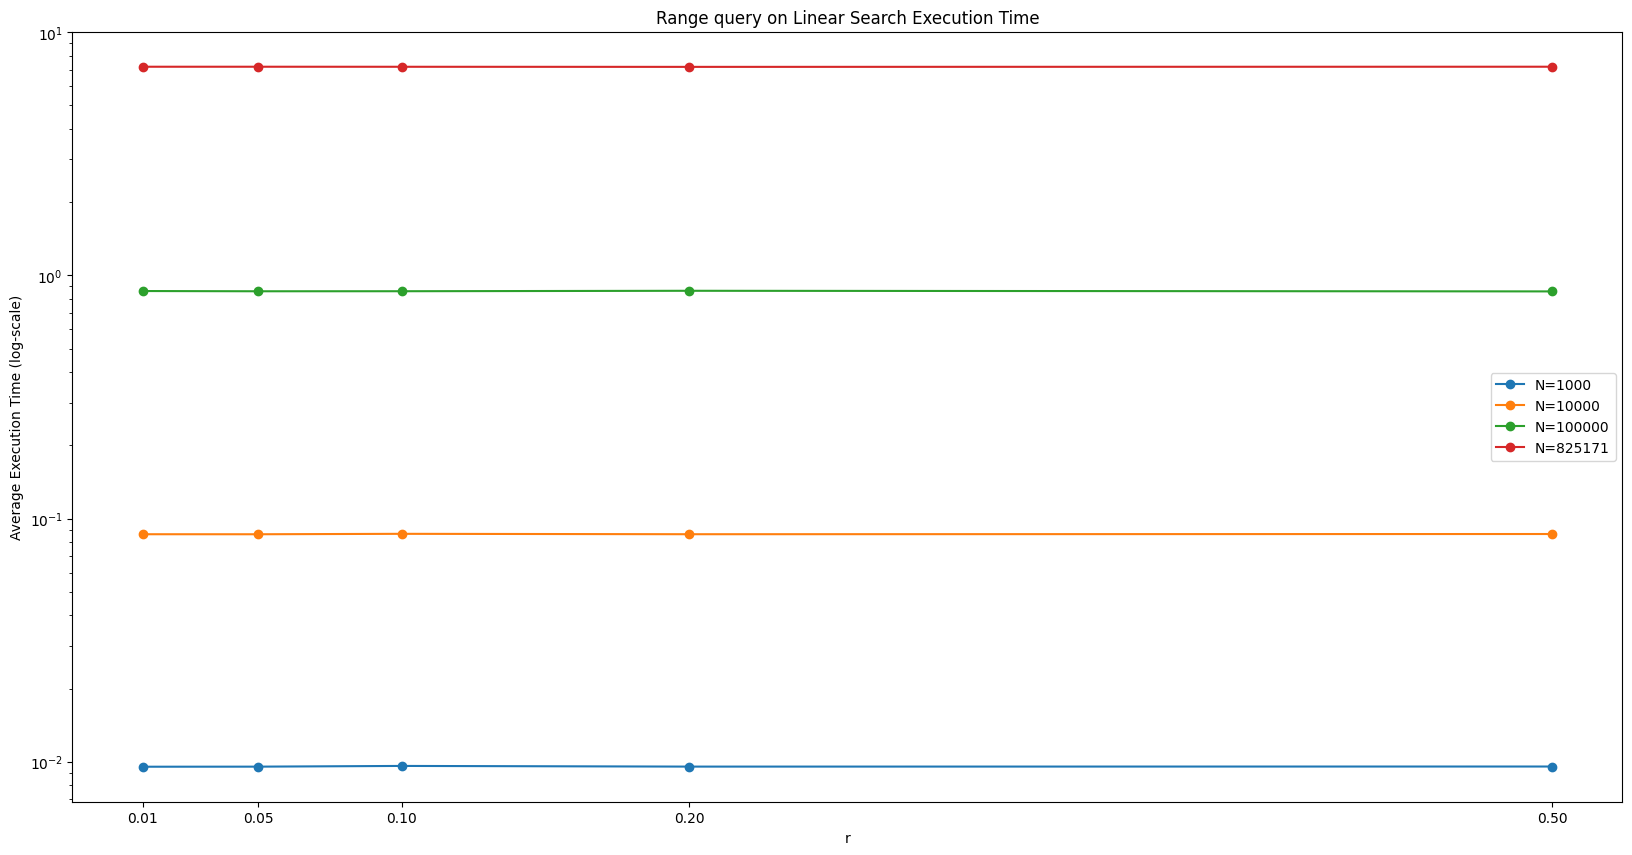

In [15]:
plot_query_execution_times(range_query_linear_search_execution_times_list, r_possible_values, N_possible_values, 'r', 'Average Execution Time (log-scale)', 'Range query on Linear Search Execution Time', 'result/range_query_linear_search_exec_time.png')

**Observations:** Just like KNN, we se that execution time increases as we increase N by a factor of O(N). This is because we have to calculate euclidian distance of target_id to all other PoIs and check for every calculated distance whether it is $<=r$. Therefore, the overall complexity of the algorithm remains O(N). Thus, execution time scales with N.

However, execution time doesn't change as r increases. This is because the complexity of linear search does not depend on r at all. It is O(N).

## Part C: Implementing Spatial Indexes: Grid Index and KD-Tree

### 1. Implement a Grid Index

In order to save space, instead of building $d \times d$ grid, I implemented grid index as a dictionary, where keys are rows and columns and values are PoI coordinates. In this approach, we create no grid cells that do not contain any data point in it, thus saving some memory.

In [253]:
# Defining Bounding Box
min_lat, min_lon = osm_data[['@lat', '@lon']].min() # South-West corner
max_lat, max_lon = osm_data[['@lat', '@lon']].max() # North-East corner

print(f'Minimum Latitude: {min_lat}, Minimum Longitude: {min_lon}\n'\
        f'Maximum Latitude: {max_lat}, Maximum Longitude: {max_lon}')

Minimum Latitude: 40.4774198, Minimum Longitude: -79.7623997
Maximum Latitude: 45.0158937, Maximum Longitude: -71.8562028


In [236]:
from matplotlib.colors import PowerNorm


def find_grid_cell(lat, lon, min_lat, min_lon, cell_size):
    row = int((lat - min_lat) // cell_size)
    col = int((lon - min_lon) // cell_size)
    return (row, col)

def build_grid_index(dataset, cell_size):
    grid_index = {}
    for i, item in dataset.iterrows():
        row, col = find_grid_cell(item['@lat'], item['@lon'], min_lat, min_lon, cell_size)
        
        if (row, col) not in grid_index:
            grid_index[(row, col)] = []
        grid_index[(row, col)].append([item['@id'], item['@lat'], item['@lon'], item['name']])
    return grid_index

def knn_grid_index(target_sample, grid_index, cell_size, k):
    # Find the cell containing the target sample
    grid_x, grid_y = find_grid_cell(target_sample['@lat'], target_sample['@lon'], min_lat, min_lon, cell_size)

    def add_neighbors(points):
        for point in points:
            if point[0] == target_sample['@id']:  # Skip the target sample itself
                continue
            distance = euclidean_distance((target_sample['@lat'], target_sample['@lon']), (point[1], point[2]))
            if len(min_heap) < k:
                heapq.heappush(min_heap, (-distance, point))
            else:
                if distance < -min_heap[0][0]: # If the distance is less than the maximum distance in the heap
                    heapq.heapreplace(min_heap, (-distance, point))
                    
    # Priority queue (min-heap) to store (distance, point)
    min_heap = []
    
    # Expand search to surrounding cells (including diagonal neighbors)
    search_radius = 1  # Start with neighboring cells in all directions
    while len(min_heap) < k:
        for dx in range(-search_radius, search_radius + 1):
            for dy in range(-search_radius, search_radius + 1):
                neighbor_points = grid_index.get((grid_x + dx, grid_y + dy), [])
                if len(neighbor_points) > 0:
                    add_neighbors(neighbor_points)
        search_radius += 1
    
    # Build a pandas DataFrame from the heap (nearest neighbors)
    result_data = []
    for distance, point in sorted(min_heap, key=lambda x: x[0]):  # Sort by distance
        result_data.append([*point, -distance])
    
    if len(result_data) > 0:
        result = pd.DataFrame(result_data, columns=['@id', '@lat', '@lon', 'name', 'target_distance'])
        return result
    
    return result_data

def range_query_grid_index(target_sample, grid_index, cell_size, r):
    grid_x, grid_y = find_grid_cell(target_sample['@lat'], target_sample['@lon'], min_lat, min_lon, cell_size)
    
    num_search_cells = math.ceil(r / cell_size)

    result = pd.DataFrame(columns=['@id', '@lat', '@lon', 'name', 'target_distance'])    
    for dx in range(-num_search_cells, num_search_cells+1):
        for dy in range(-num_search_cells, num_search_cells+1):
            search_cell = grid_index.get((grid_x + dx, grid_y + dy), [])
            for point in search_cell:
                distance = euclidean_distance((point[1], point[2]), (target_sample['@lat'], target_sample['@lon']))
                if distance <= r and distance != 0: # Exclude the target sample
                    result = pd.concat([result, pd.DataFrame(columns=['@id', '@lat', '@lon', 'name', 'target_distance'], data=[[*point, distance]])], ignore_index=True)
    return result
    

####  Sanity Check: 5NN on grid index for whole dataset
Building the grid index code took 40.8s.

In [207]:
# Defining Bounding Box
min_lat, min_lon = osm_data[['@lat', '@lon']].min() # South-West corner
max_lat, max_lon = osm_data[['@lat', '@lon']].max() # North-East corner

print(f'Minimum Latitude: {min_lat}, Minimum Longitude: {min_lon}\n'\
        f'Maximum Latitude: {max_lat}, Maximum Longitude: {max_lon}')

C = 0.01


grid_index = build_grid_index(osm_data, C)
print(f"Size of grid index dictionary: {len(grid_index)}")


Size of grid index dictionary: 92175


In [210]:
k = 5

target_id = 10286555485
target_sample = osm_data[osm_data['@id'] == target_id].iloc[0]

knn_grid_index_sample_result = knn_grid_index(target_sample, grid_index, C, k)
knn_grid_index_sample_result.sort_values(by='target_distance', inplace=True) # Sort by distance to compare with linear search and KD Tree result
knn_grid_index_sample_result.reset_index(drop=True)

,@id,@lat,@lon,name,target_distance
0,10286555484,40.953624,-74.068873,NaN,0.000242
1,10286555481,40.953588,-74.068656,NaN,0.000463
2,10286555483,40.954115,-74.068730,NaN,0.000590
3,10286555503,40.953990,-74.069609,NaN,0.000594
4,10286555486,40.954327,-74.068970,NaN,0.000676


#### Evaluate KNN on Grid Index Performance

In [276]:
def sample_dataset(dataset, N):
    # Sampling dataset of size N
    sample_data = dataset.sample(n=N)
    target_id = np.random.choice(dataset['@id'])
    target_sample = dataset[dataset['@id'] == target_id].iloc[0]
    
    min_lat, min_lon = dataset[['@lat', '@lon']].min() # South-West corner
    max_lat, max_lon = dataset[['@lat', '@lon']].max() # North-East corner
    
    return sample_data, target_sample, min_lat, min_lon, max_lat, max_lon

def measure_execution_time_grid_index(grid_index, cell_size, val, func):
    # Selecting a random target_id
    target_id = np.random.choice(osm_data['@id'])
    target_sample = osm_data[osm_data['@id'] == target_id].iloc[0]
    # print("target_id: ", target_id)
    # Finding the k nearest neighbors and measuring execution time
    start_time = time.time()
    func(target_sample, grid_index, cell_size, val)
    end_time = time.time()
    
    return end_time - start_time
# TODO: fix before pushing
def plot_query_execution_times_grid_index(execution_times_list, target_possible_values, cell_size_possible_values, N_possible_values, x_label, y_label, title, save_path, log_scale=True):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    
    for i, N in enumerate(N_possible_values):
        ax = axes[i // 2, i % 2]
        ax.set_xticks(target_possible_values)
        ax.set_title(f'N={N}')
        c_exec_times = execution_times_list[i: i+len(cell_size_possible_values)]
        for j, cell_size in enumerate(cell_size_possible_values):
            ax.plot(target_possible_values, c_exec_times[j], label=f'C={cell_size}', marker='o')
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            ax.legend()
            ax.set_yscale('log')
            
    
    fig.suptitle(title)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

The below code block took 2m to run.

In [212]:
cell_size_possible_values = [0.01, 0.05, 0.1, 0.2]
k_possible_values = [1, 5, 10, 50, 100, 500]
N_possible_values = [1000, 10000, 100000, 825171]
knn_grid_index_execution_times_list = [] # holds the execution times for different values of C and k

logger.info('KNN Grid Index Execution Time Measurement')

for N in N_possible_values:
    sample_data, target_sample, min_lat, min_lon, max_lat, max_lon = sample_dataset(osm_data, N)
    for C in cell_size_possible_values:
        grid_index = build_grid_index(sample_data, C)
        execution_times = []
        for k in k_possible_values:
            k_specific_execution_times = []
            for _ in range(10):
                k_specific_execution_times.append(measure_execution_time_grid_index(grid_index, C, k, knn_grid_index))
            logger.info(f'N={N}, C={C}, k={k}, Average Execution Time={np.mean(k_specific_execution_times)} seconds.')
            print(f'N={N}, C={C}, k={k}, Average Execution Time={np.mean(k_specific_execution_times)} seconds.')
            execution_times.append(np.mean(k_specific_execution_times))
        knn_grid_index_execution_times_list.append(execution_times)
    

N=1000, C=0.01, k=1, Average Execution Time=0.0002605676651000977 seconds.
N=1000, C=0.01, k=5, Average Execution Time=0.0009865999221801759 seconds.
N=1000, C=0.01, k=10, Average Execution Time=0.0006411075592041016 seconds.
N=1000, C=0.01, k=50, Average Execution Time=0.0024245023727416993 seconds.
N=1000, C=0.01, k=100, Average Execution Time=0.007866573333740235 seconds.
N=1000, C=0.01, k=500, Average Execution Time=0.025757598876953124 seconds.
N=1000, C=0.05, k=1, Average Execution Time=0.00034265518188476564 seconds.
N=1000, C=0.05, k=5, Average Execution Time=0.0005254983901977539 seconds.
N=1000, C=0.05, k=10, Average Execution Time=0.0006629467010498047 seconds.
N=1000, C=0.05, k=50, Average Execution Time=0.0010876893997192384 seconds.
N=1000, C=0.05, k=100, Average Execution Time=0.0013091325759887694 seconds.
N=1000, C=0.05, k=500, Average Execution Time=0.005097532272338867 seconds.
N=1000, C=0.1, k=1, Average Execution Time=0.0006331682205200195 seconds.
N=1000, C=0.1, k

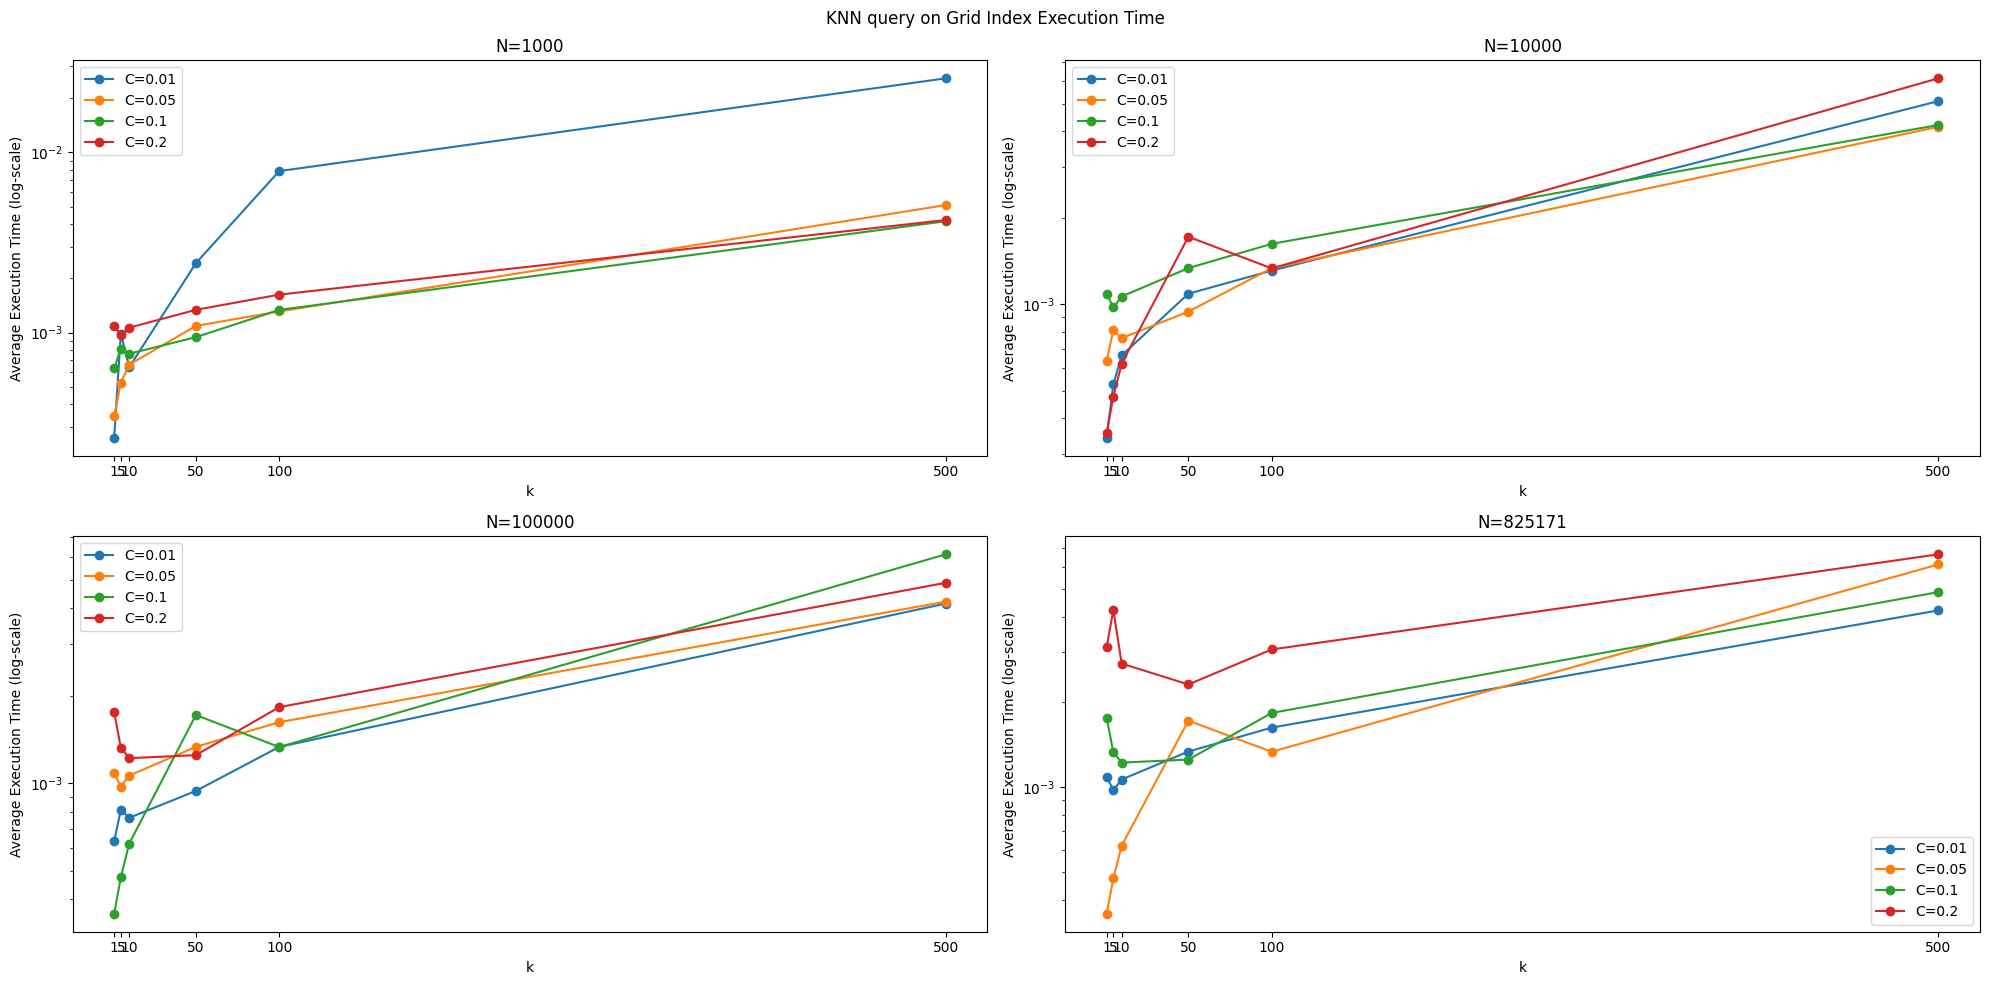

In [229]:
plot_query_execution_times_grid_index(knn_grid_index_execution_times_list, k_possible_values, cell_size_possible_values, N_possible_values, 'k', 'Average Execution Time (log-scale)', 'KNN query on Grid Index Execution Time', 'result/knn_grid_index_exec_time.png')

**Observations:**

As we increase N, in general we can see that overall execution times increase, but it is significantly lower than linear search. For example, it took 0.3s for N=825171 and k=500, whereas in linear search, it took ~7 seconds on average to execute. For a single value of N, we expect for execution time to increase as we increase K, which is evident in all the plots. Also, we expect for execution time to increase as we increase C for a particular N and K. The effect of increase in cell size is more visible in much larger N (last plot), but it is not significant in smaller Ns. This might be due to choosing different query nodes at each iteration of evaluation and distribution of points in cells are skewed. This means that for smaller cell sizes we have to expand our search space more to find the k nearest neighbors.

In general the time complexity of KNN using grid depends on:
- cell size 
- radius to navigate neighboring cells
- Number of points in each cell. In reality the distribution of points in cells are skewed and we have to navigate all neighboring cells.
- Maintaining KNNs in priority queue takes O(klogk).

In general, KNN takes $O(p\times(\frac{r}{c})^2 + klogk)$, which is still much less than linear search.

#### Sanity Check: Range Query using Grid Index

In [234]:

# Defining Bounding Box
min_lat, min_lon = osm_data[['@lat', '@lon']].min() # South-West corner
max_lat, max_lon = osm_data[['@lat', '@lon']].max() # North-East corner

print(f'Minimum Latitude: {min_lat}, Minimum Longitude: {min_lon}\n'\
        f'Maximum Latitude: {max_lat}, Maximum Longitude: {max_lon}')

C = 0.01

grid_index = build_grid_index(osm_data, C)
print(f"Size of grid index dictionary: {len(grid_index)}")

r = 0.01
target_id = 10286555485
target_sample = osm_data[osm_data['@id'] == target_id].iloc[0]

Minimum Latitude: 40.4774198, Minimum Longitude: -79.7623997
Maximum Latitude: 45.0158937, Maximum Longitude: -71.8562028
Size of grid index dictionary: 92175


In [237]:
range_query_grid_index_sample_result = range_query_grid_index(target_sample, grid_index, C, r)
print(f"Size of range query (eliminating query node itself): {len(range_query_grid_index_sample_result)}.")
range_query_grid_index_sample_result.head()

Size of range query (eliminating query node itself): 341.


,@id,@lat,@lon,name,target_distance
0,158873706,40.945291,-74.07359,Paramus,0.009496
1,9671884491,40.945481,-74.072569,SW Archery,0.008884
2,9671884492,40.945629,-74.072582,Kook Hwa Bakery Cafe,0.008754
3,9671884493,40.945777,-74.072596,Kiku,0.008624
4,103284088,40.944234,-74.070314,NaN,0.009507


The size matches what we got from linear search and Kd-tree. However, the ordering might be different.

#### Evaluating Grid Index on Range Query

The below code took 2 hours to execute.

In [239]:
cell_size_possible_values = [0.01, 0.05, 0.1, 0.2]
r_possible_values = [0.01, 0.05, 0.1, 0.2, 0.5]
N_possible_values = [1000, 10000, 100000, 825171]

range_query_grid_index_execution_times_list = [] # holds the execution times for different values of C and r

logger.info('Range Query using Grid Index Execution Time Measurement')

for N in N_possible_values:
    sample_data, target_sample, min_lat, min_lon, max_lat, max_lon = sample_dataset(osm_data, N)
    for C in cell_size_possible_values:
        grid_index = build_grid_index(sample_data, C)
        execution_times = []
        for r in r_possible_values:
            r_specific_execution_times = []
            for _ in range(10):
                r_specific_execution_times.append(measure_execution_time_grid_index(grid_index, C, r, range_query_grid_index))
            logger.info(f'N={N}, C={C}, r={r}, Average Execution Time={np.mean(r_specific_execution_times)} seconds.')
            print(f'N={N}, C={C}, r={r}, Average Execution Time={np.mean(r_specific_execution_times)} seconds.')
            execution_times.append(np.mean(r_specific_execution_times))
        range_query_grid_index_execution_times_list.append(execution_times)

N=1000, C=0.01, r=0.01, Average Execution Time=0.0012242794036865234 seconds.
N=1000, C=0.01, r=0.05, Average Execution Time=0.0026334524154663086 seconds.
N=1000, C=0.01, r=0.1, Average Execution Time=0.005720853805541992 seconds.
N=1000, C=0.01, r=0.2, Average Execution Time=0.005543351173400879 seconds.
N=1000, C=0.01, r=0.5, Average Execution Time=0.10531222820281982 seconds.
N=1000, C=0.05, r=0.01, Average Execution Time=0.0009984970092773438 seconds.
N=1000, C=0.05, r=0.05, Average Execution Time=0.003010272979736328 seconds.
N=1000, C=0.05, r=0.1, Average Execution Time=0.005636930465698242 seconds.
N=1000, C=0.05, r=0.2, Average Execution Time=0.036716580390930176 seconds.
N=1000, C=0.05, r=0.5, Average Execution Time=0.004354238510131836 seconds.
N=1000, C=0.1, r=0.01, Average Execution Time=0.0011456012725830078 seconds.
N=1000, C=0.1, r=0.05, Average Execution Time=0.0018230676651000977 seconds.
N=1000, C=0.1, r=0.1, Average Execution Time=0.01212453842163086 seconds.
N=1000

Traceback (most recent call last):
  File "/home/users/bita/anaconda3/envs/pyg/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1977638/419376837.py", line 17, in <module>
    r_specific_execution_times.append(measure_execution_time_grid_index(grid_index, C, r, range_query_grid_index))
  File "/tmp/ipykernel_1977638/2245428187.py", line 19, in measure_execution_time_grid_index
    func(target_sample, grid_index, cell_size, val)
  File "/tmp/ipykernel_1977638/1276286208.py", line -1, in range_query_grid_index
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/users/bita/anaconda3/envs/pyg/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/users/bita/anaconda3/envs/pyg/lib/python3.10/si

In [1]:
plot_query_execution_times_grid_index(range_query_grid_index_execution_times_list, r_possible_values, cell_size_possible_values, N_possible_values, 'r', 'Average Execution Time (log-scale)', 'Range query on Grid Index Execution Time', 'result/range_query_grid_index_exec_time.png')

NameError: name 'plot_query_execution_times_grid_index' is not defined

**Observations on Range Query:**

Time Complexity for Range Query: $O(p \times (\frac{r}{c})^2)$ since we need to find the grid cell that contains target point and need to navigate all the neighboring cells. PoI distribution is skewed, meaning that we might have many points in one cell and no point in some other cells. If we assume the average of the number of points are $p$ in each cell (can be mean of distribution of points in grid), the overall complexity becomes $O(p \times (\frac{r}{c})^2)$.

As N increases, we don't see any noticable increase/decrease in execution time. This is because the time complexity depends on how many grid cells are around radius r of the target node and also how many nodes are in each cell. The distribution of points in each cell is skewed and that's why we don't have consistent increase/decrease patterns as we vary C. However, as we expand r, we have to navigate more cells which would be squared in terms of radius r and cell size c. That's why as we increase r in all plots with all C possible values, we observe increase in execution times.

## 2. Implement a KD-Tree Index

In [243]:
class node:
    def __init__(self, record, left=None, right=None):# recode = pandas row of [@id	@lat	@lon	name]
        self.record = record
        self.left = left
        self.right = right

def axis_mapper(axis):
    """
    helper function to map axis to column name in pandas
    """
    return '@lat' if axis == 0 else '@lon'

def build_kd_tree(dataset):    
    def insert_node(root, record, depth):
        if root is None:
            return node(record)
        
        axis = axis_mapper(depth % 2)
        if record[axis] < root.record[axis]:
            root.left = insert_node(root.left, record, depth+1)
        else:
            root.right = insert_node(root.right, record, depth+1)
        return root
            
    root = None    
    for i, item in dataset.iterrows():
        root = insert_node(root, item, 0)
        
    return root

def find_knn_kd_tree(root, query, axis, nearest_neighbors, distances, k):
    if root is None:
        return nearest_neighbors, distances

    # Determine which subtree to navigate next
    cut_dim = axis_mapper(axis)
    if query[cut_dim] < root.record[cut_dim]:  # left subtree
        nearest_neighbors, distances = find_knn_kd_tree(root.left, query, (axis+1) % 2, nearest_neighbors, distances, k)
        other_branch = root.right
    else:
        nearest_neighbors, distances = find_knn_kd_tree(root.right, query, (axis+1) % 2, nearest_neighbors, distances, k)
        other_branch = root.left

    # Calculate the distance from the query point to the current node
    dist = euclidean_distance((root.record['@lat'], root.record['@lon']), (query['@lat'], query['@lon']))

    # Add current node if it is closer and update nearest_neighbors list
    if dist != 0:  # Avoid the query point itself
        if len(distances) < k:  # If we haven't found k neighbors yet, just add it
            distances.append(dist)
            nearest_neighbors.append(root.record)
        else:  # Only add if the current point is closer than the farthest in the list
            max_dist = max(distances) if distances else float('inf')  # Set max_dist to infinity if distances is empty
            if dist < max_dist:
                # Replace the farthest neighbor
                max_idx = distances.index(max_dist)
                distances[max_idx] = dist
                nearest_neighbors[max_idx] = root.record

        # Sort neighbors by distance to maintain order
        combined = sorted(zip(distances, nearest_neighbors), key=lambda x: x[0])
        distances, nearest_neighbors = zip(*combined)
        distances = list(distances)
        nearest_neighbors = list(nearest_neighbors)

    # Navigate the other subtree if necessary
    max_dist = max(distances) if distances else float('inf')  # Check again if distances is non-empty
    if abs(query[cut_dim] - root.record[cut_dim]) < max_dist or len(distances) < k:
        nearest_neighbors, distances = find_knn_kd_tree(other_branch, query, (axis+1) % 2, nearest_neighbors, distances, k)

    return nearest_neighbors, distances

def range_query_kd_tree(root, query, axis, r, result):
    if root is None:
        return
    
    cut_dim = axis_mapper(axis)
    dist = euclidean_distance((root.record['@lat'], root.record['@lon']), (query['@lat'], query['@lon']))  
    if dist <= r and dist != 0: # discard the query node itself by adding dist != 0
        result.append(root.record)
        
    if query[cut_dim] - r < root.record[cut_dim]:
        range_query_kd_tree(root.left, query, (axis+1)%2, r, result)
    if query[cut_dim] + r >= root.record[cut_dim]:
        range_query_kd_tree(root.right, query, (axis+1)%2, r, result)

Building Tree took 3m 48.7s on the whole 1.5 million size dataset.

In [241]:
root = build_kd_tree(osm_data)

Testing KNN on KD-tree using the same target_id as in Linear Search and Grid Index to ensure correctness of the algorithm. The below code yields similar results to linear search and grid index. Thus, we are sure of its correctness.

In [258]:
target_id = 10286555485
target_sample = osm_data[osm_data['@id'] == target_id].iloc[0]

k = 5

nearest_neighbors, best_dists = find_knn_kd_tree(root, target_sample, 0, [], [], k)

# build a pandas data frame from the nearest neighbors list
knn_kd_tree_result = pd.DataFrame(columns=['@id', '@lat', '@lon', 'name', 'distance'], data=[(*point, distance) for point, distance in zip(nearest_neighbors, best_dists)])

knn_kd_tree_result

,@id,@lat,@lon,name,distance
0,10286555484,40.953624,-74.068873,NaN,0.000242
1,10286555481,40.953588,-74.068656,NaN,0.000463
2,10286555483,40.954115,-74.068730,NaN,0.000590
3,10286555503,40.953990,-74.069609,NaN,0.000594
4,10286555486,40.954327,-74.068970,NaN,0.000676


In [259]:
r = 0.01
result = []
range_query_kd_tree(root, target_sample, 0, r, result)
print(f" Size of range query (eliminating query node itself): {len(result)}.")

 Size of range query (eliminating query node itself): 341.


The size matches from linear search and grid index. The ordering might be different due to different data structures used.

### KNN Execution Time Evaluation Setting 1: Building a new Tree for each N

In this setting, we evaluate the performance of KNN using kd-tree while varying N, k, and target_id. When varying N, we have to build a new tree from scratch. 


The overall execution time on my laptop for the below code was about 2 minutes.

In [260]:
# Option 1: Build a new Tree for each N
def sample_dataset(dataset, N):
    # Sampling dataset of size N
    sample_data = dataset.sample(n=N)
    # Selecting a random target_id
    target_id = np.random.choice(dataset['@id'])
    target_sample = osm_data[osm_data['@id'] == target_id].iloc[0]
    
    return sample_data, target_sample

def measure_execution_time_kd_tree(root, k):
    start_time = time.time()
    nearest_neighbors, best_dists = find_knn_kd_tree(root, target_sample, 0, [], [], k)
    end_time = time.time()
    
    return end_time - start_time

k_possible_values = [1, 5, 10, 50, 100, 500]
N_possible_values = [1000, 10000, 100000, 825171]

logger.info('KNN on KD-Tree Execution Time Measurement')
knn_kd_tree_execution_times_list = [] # holds the execution times for different values of k and N

# Option 2: Build a new Tree for each N
for N in N_possible_values:
    sampled_data, target_sample = sample_dataset(osm_data, N)
    tree_root = build_kd_tree(sampled_data)
    execution_times = []
    for k in k_possible_values:
        k_specific_execution_times = []
        for _ in range(10):
            k_specific_execution_times.append(measure_execution_time_kd_tree(tree_root, k))   
        logger.info(f'N={N}, k={k}, Average Execution Time={np.mean(k_specific_execution_times)} seconds.')
        print(f'N={N}, k={k}, Average Execution Time={np.mean(k_specific_execution_times)} seconds.')
        execution_times.append(np.mean(k_specific_execution_times))
    knn_kd_tree_execution_times_list.append(execution_times)

N=1000, k=1, Average Execution Time=0.00015079975128173828 seconds.
N=1000, k=5, Average Execution Time=0.00033824443817138673 seconds.
N=1000, k=10, Average Execution Time=0.000542759895324707 seconds.
N=1000, k=50, Average Execution Time=0.002396225929260254 seconds.
N=1000, k=100, Average Execution Time=0.00628654956817627 seconds.
N=1000, k=500, Average Execution Time=0.03380558490753174 seconds.
N=10000, k=1, Average Execution Time=0.0003255605697631836 seconds.
N=10000, k=5, Average Execution Time=0.000485992431640625 seconds.
N=10000, k=10, Average Execution Time=0.0011018753051757813 seconds.
N=10000, k=50, Average Execution Time=0.002848172187805176 seconds.
N=10000, k=100, Average Execution Time=0.004036927223205566 seconds.
N=10000, k=500, Average Execution Time=0.05196843147277832 seconds.
N=100000, k=1, Average Execution Time=0.0007435321807861328 seconds.
N=100000, k=5, Average Execution Time=0.000950479507446289 seconds.
N=100000, k=10, Average Execution Time=0.001165652

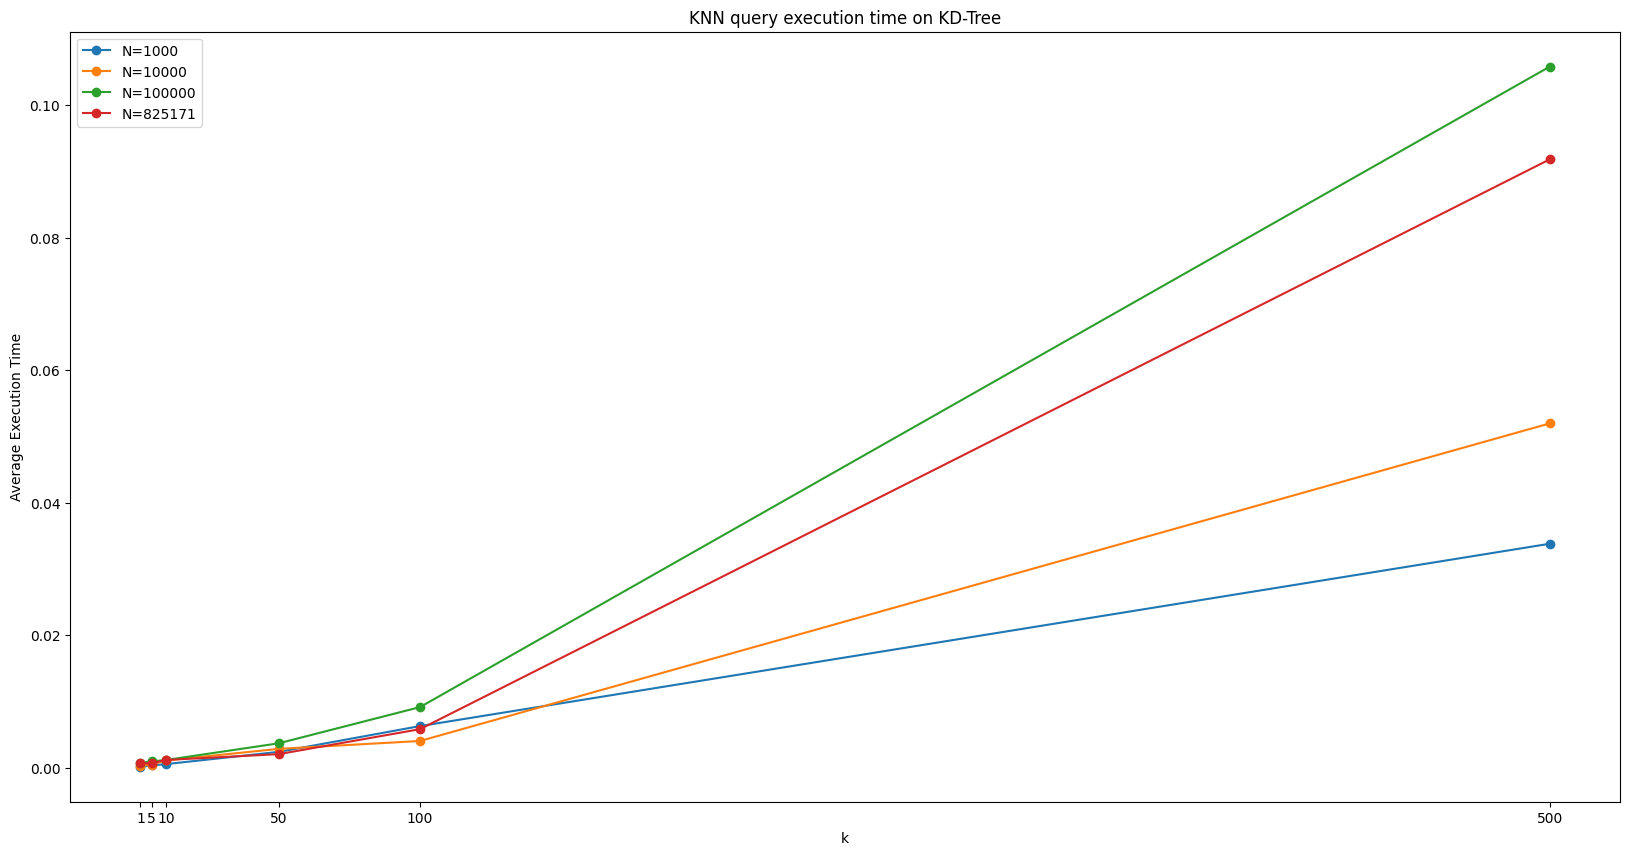

In [263]:
# Non-logarithmic scale:
plot_query_execution_times(knn_kd_tree_execution_times_list, k_possible_values, N_possible_values, 'k', 'Average Execution Time', 'KNN query execution time on KD-Tree','result/knn_kd_tree_exec_time_nolog_scale.png', log_scale=False)

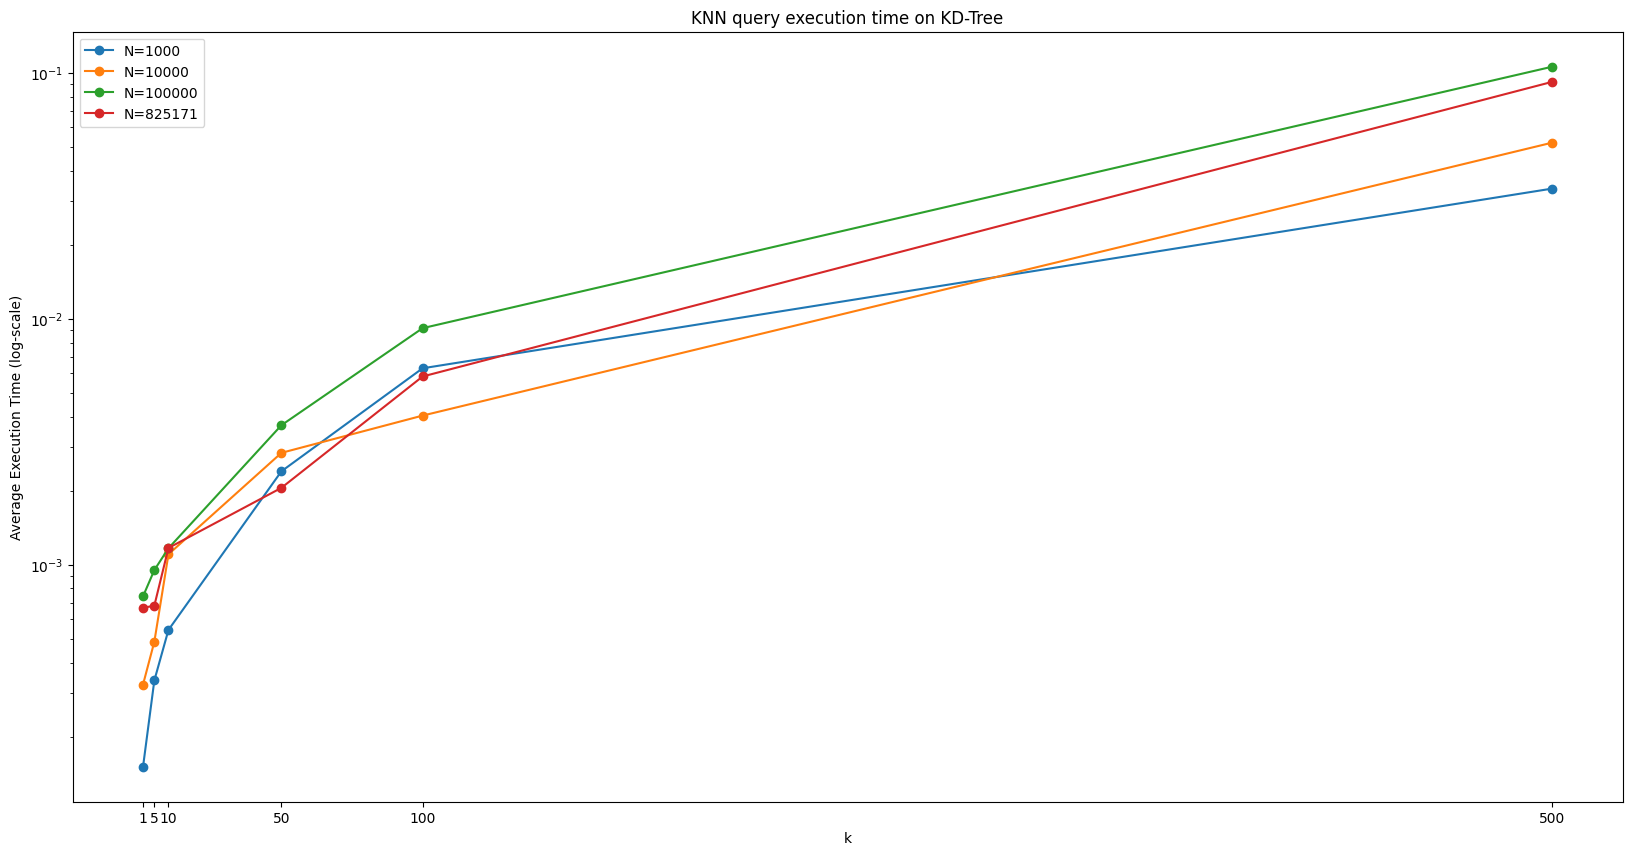

In [264]:
#logarithmic scale:
plot_query_execution_times(knn_kd_tree_execution_times_list, k_possible_values, N_possible_values, 'k', 'Average Execution Time (log-scale)', 'KNN query execution time on KD-Tree','result/knn_kd_tree_exec_time_log_scale.png', log_scale=True)

**Observations:**

In this section, I provided two views of execution time of KNN using KD trees. In the first one, the y-axis is raw execution time whereas in the second one, y-axis is in logarithmic scale. The reason for the first plot was to emphasize that as we increase k, it takes longer to finish KNN bc we have to maintain a list of K-nearest neighbors. Therefore, the overall complexity is $O(logn+k)$. The second plot provides a view that shows as we increase N, the execution time does not increase as much as when we did KNN using linear search. To be specific, when $N=827,171$, linear search took around 7-8 seconds on average to perform KNN whereas KD-tree took **0.09 second** for all Ks and grid index took 0.8 s when $N=827,171$ and $C=0.2$.


### Range Query Execution Time

The code took 3 minutes to run.

In [250]:
# Option 1: Build a new Tree for each N
def sample_dataset(dataset, N):
    # Sampling dataset of size N
    sample_data = dataset.sample(n=N)
    # Selecting a random target_id
    target_id = np.random.choice(dataset['@id'])
    target_sample = dataset[dataset['@id'] == target_id].iloc[0]
    
    return sample_data, target_sample

def measure_range_query_execution_time_kd_tree(root, target_sample,r):
    start_time = time.time()
    result = []
    range_query_kd_tree(root, target_sample, 0, r, result)
    end_time = time.time()
    
    return end_time - start_time

r_possible_values = [0.01, 0.05, 0.1, 0.2, 0.5]
N_possible_values = [1000, 10000, 100000, 825171]
logger.info('Range Query on KD-Tree Execution Time Measurement')
range_query_kd_tree_execution_times_list = [] # holds the execution times for different values of

# Option 1: Build a new Tree for each N
for N in N_possible_values:
    sampled_data, target_sample = sample_dataset(osm_data, N)
    tree_root = build_kd_tree(sampled_data)
    execution_times = []
    for r in r_possible_values:
        r_specific_execution_times = []
        for _ in range(10):
            r_specific_execution_times.append(measure_range_query_execution_time_kd_tree(tree_root, target_sample, r))    
        logger.info(f'N={N}, r={r}, Average Execution Time={np.mean(r_specific_execution_times)} seconds.')
        print(f'N={N}, r={r}, Average Execution Time={np.mean(r_specific_execution_times)} seconds.')
        execution_times.append(np.mean(r_specific_execution_times))
    range_query_kd_tree_execution_times_list.append(execution_times)

N=1000, r=0.01, Average Execution Time=0.0003272056579589844 seconds.
N=1000, r=0.05, Average Execution Time=0.0004179716110229492 seconds.
N=1000, r=0.1, Average Execution Time=0.0005773067474365235 seconds.
N=1000, r=0.2, Average Execution Time=0.0009603500366210938 seconds.
N=1000, r=0.5, Average Execution Time=0.002359318733215332 seconds.
N=10000, r=0.01, Average Execution Time=0.00030231475830078125 seconds.
N=10000, r=0.05, Average Execution Time=0.000587296485900879 seconds.
N=10000, r=0.1, Average Execution Time=0.000563359260559082 seconds.
N=10000, r=0.2, Average Execution Time=0.0016199111938476562 seconds.
N=10000, r=0.5, Average Execution Time=0.003750514984130859 seconds.
N=100000, r=0.01, Average Execution Time=0.002646660804748535 seconds.
N=100000, r=0.05, Average Execution Time=0.012323236465454102 seconds.
N=100000, r=0.1, Average Execution Time=0.03621091842651367 seconds.
N=100000, r=0.2, Average Execution Time=0.10797338485717774 seconds.
N=100000, r=0.5, Average

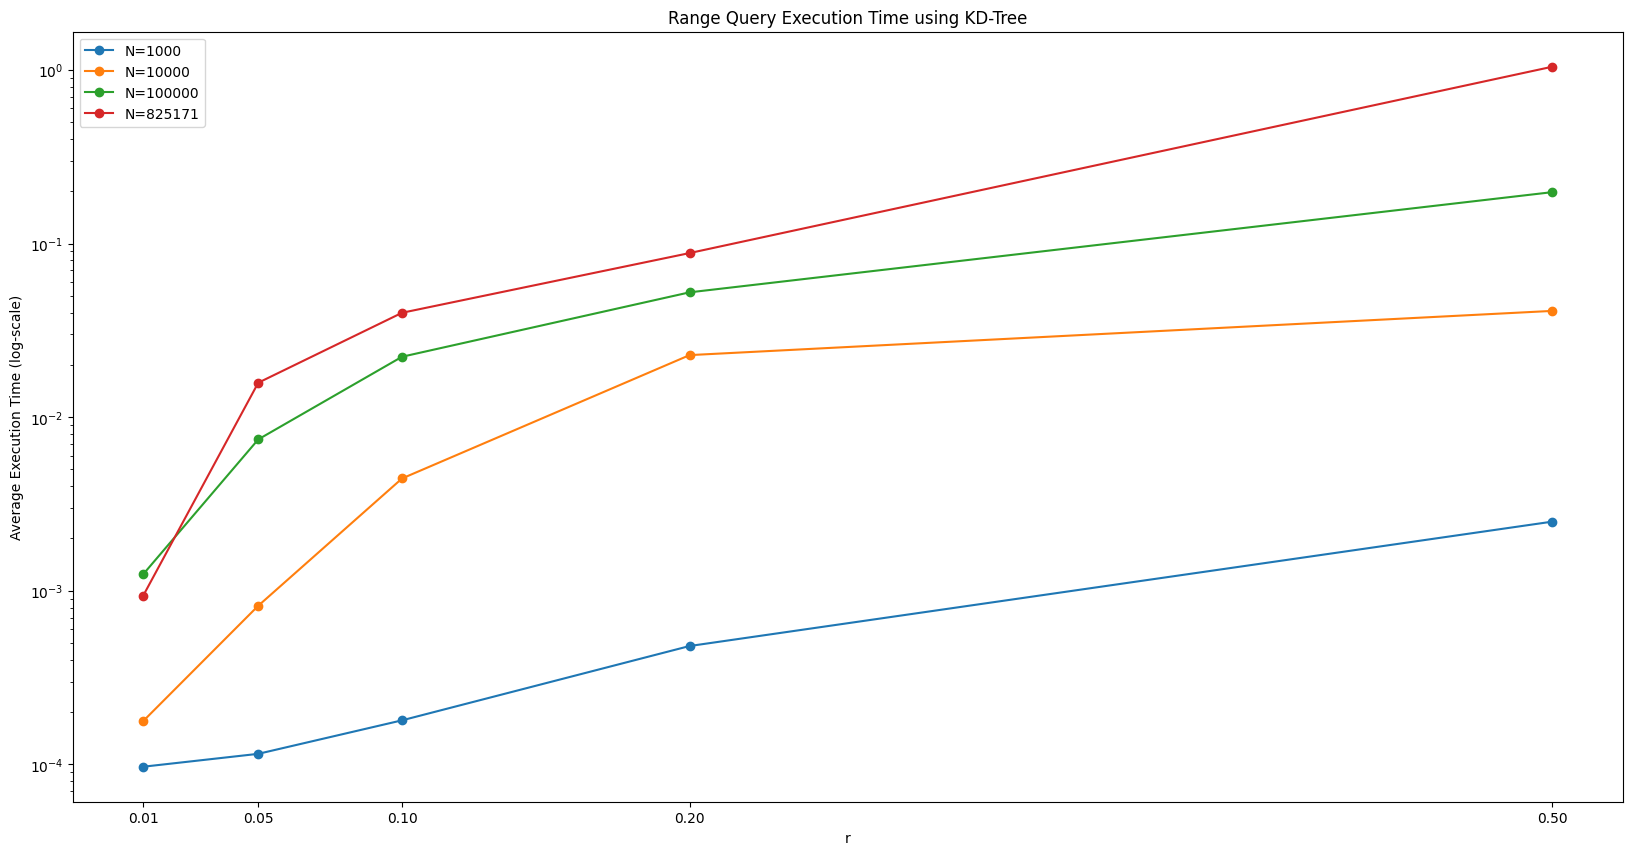

In [35]:
plot_query_execution_times(range_query_kd_tree_execution_times_list, r_possible_values, N_possible_values, 'r', 'Average Execution Time (log-scale)', 'Range Query Execution Time using KD-Tree','result/knn_kd_tree_exec_time_log_scale.png')

**Observations:**

As we increase r, the execution time increases because we are expanding our search space and we have to visit more subtrees.The best case for range query on kdtree is $O(\sqrt{n}+K)$ and the worst case is $O(N)$, which is when range is large and we have to visit all the nodes. 

The execution time however, is much less than grid index and linear search. When $N=825171$, execution time for linear search was around 7s and grid index was up to 30s which is the worst. In contrast in KD-tree took 2.5 s when r=0.5. Grid Index for range query is the worst because it is squared in terms of radius and cell size, which can lead to $O(n^2)$ if one point lies in each cell and cell size is small enough. 


## 3. Run Queries and Compare Performance:

- Use your implemented Grid Index and KD-Tree to run the same kNN and range queries with the
same configurations (values of k, r, and dataset sizes) as in the brute force approach.
    - Answer: already done
- Verify the correctness of your results by comparing the outcomes from the brute force approach with
those from the indexing methods.
    - Answer: done after each index's implementation. Check Sanity Checks sections.
- Measure and report the query execution times for each indexing method.
    - Answer: done in each section as well as the corresponding plots.
- Compare the performance of the Grid Index and KD-Tree against each other and against the brute
force approach.
    - Grid Index vs KD-Tree: As discussed in respective sections, KD-tree has the best performance for KNN O(logN+K) and range query $O(\sqrt{n}+K). Grid Index performs in $O(p\times (r/c)^2)$ for KNN and $O(p\times (r/c)^2 + klogk)$ for range query. It can become incredibly worse than linear search if cell sizes  are too small and distribution of items in each cell is skewed, which often happens.   
    - Grid Index vs KD-Tree vs linear search: For KNN, KD-tree is the best of all, then Grid Index linear search is not good at all. For range query, Grid index can perform the worst as dataset size increases, r (radius of the search space) increases, but larger cell sizes lead to lower execution time because time complexity is O((r/c)^2). Grid index is better for KNN and not range queries. KD-Tree is the best for both queries and linear search is better for range query, but not KNN.
